# LSN Esercitazione 08

## Esercizio 08.1

La richiesta di questo esercizio è quella di implementare un codice Monte Carlo che stimi il valore medio dell'Hamiltoniana

$$\hat H=-\frac{\hbar}{2}\frac{\partial^2}{\partial x^2}+x^4+\frac{5}{2}x^2$$


utilizzando una funzione d'onda di prova proporzionale alla somma di due gaussiane, il cui modulo quadro è:

$$|\Psi_T^{\sigma,\mu}(x)|^2 =|\mathcal{N}|^2 \left(e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}\right)^2$$

**N.B.**: Da qui in poi ignoreremo la normalizzazione della funzione d'onda, perché questa verrà semplificata nei rapporti ad ogni passaggio.

Per calcolare questo valore medio (**a fissati valori di $\mu$ e $\sigma$**) abbiamo utilizzato l'algoritmo di Metropolis (vedi funzione <font face="Fira Code" size=3>Metropolis()</font> nel file <font face="Courier" size=3>main01.cpp</font>). per generare una serie di $M$ punti $x_i$ nello spazio 1D, in cui abbiamo valutato il valore della funzione d'onda. Dopo aver generato questi punti abbiamo calcolato (in <font face="Fira Code" size=3>Measure()</font>) il valore dell'energia locale

$$E_\text{loc}(x) = \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$

e, utilizzando questi $M$ valori, abbiamo calcolato la media dell'hamiltoniana:

$$ \langle\hat{H}\rangle_T=\frac{1}{M} \sum_{i=1}^M E_\text{loc}(x_i)$$

Per calcolare l'incertezza su questa media abbiamo, come al solito, utilizzato il data blocking.

## Esercizio 08.2

Ora ci viene richiesto di trovare i valori di $\mu$ e $\sigma$ che minimizzano $\langle\hat{H}\rangle_T$ calcolato nell'esercizio precedente e calcolare questo valore.
Utilizzando il codice python che ci è stato fornito per calcolare numericamente le funzioni d'onda dell'hamiltoniana, plottiamo la distribuzione di probabilità dello stato fondamentale, $|\Psi_{GS}(x)|^2$.

Grazie a questo plot possiamo stimare, più o meno precisamente, i valori di $\mu$ e $\sigma$:
1. Per stimare $\mu$, ovvero la media delle nostre gaussiane, cerchiamo il valore di $x$ per cui la pdf è massima.
2. Per quanto riguarda $\sigma$ la stima è più "a occhio". Infatti, la parte sinistra (o destra) del grafico è simile a una gaussiana (lo scopo dell'esercizio è proprio quello di riprodurre queste funzioni d'onda utilizzando una somma di due distribuzioni normali!); per questa ragione consideriamo la FWHM (full width at half maximum) del grafico e ne calcoliamo la metà (per avere una stima della FWHM della gaussiana). Da questa possiamo ottenere $\sigma$ con la seguente formula

$$\sigma=\frac{\text{FWHM}_{|\Psi|^2}}{2*2\sqrt{2\ln{2}}}$$

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
from scipy.optimize import minimize_scalar
from scipy.integrate import quad

plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # fontsize of the legend

In [3]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

Stima di mu = 0.8
Stima di sigma = 0.6


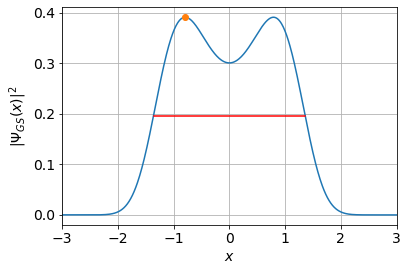

In [4]:
plt.plot(x, psi[0]**2)
plt.xlabel(r'$x$')
plt.ylabel(r'$|\Psi_{GS}(x)|^2$')
plt.xlim((-3, 3))

# Indice per cui p(x) è massima
index = np.argmax(psi[0]**2)

# Valore di x per cui p(x) è massima (è una stima di mu)
MU = abs(round(x[index], 1))
print("Stima di mu =", MU)

# Plot del punto di massimo
plt.plot(x[index], (psi[0][index])**2, 'o')


# Ora pensiamo a sigma
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Elemento di psi[0]**2 che è più vicino all' half maximum
nearest = find_nearest(psi[0]**2, (psi[0][index])**2/2)

FWHM = 2 * abs(x[nearest])

# Stima di sigma
SIGMA = round(FWHM/2/(2*np.sqrt(2*np.log(2))), 1)
print("Stima di sigma =", SIGMA)

# Plot della linea di FWHM
x1 = np.linspace(-FWHM/2, FWHM/2)
y1 = x1 * 0 + (psi[0][index])**2/2
plt.plot(x1, y1, 'r-')

plt.grid(True)
plt.show()

Dopo aver stimato $\mu$ e $\sigma$ possiamo inserire questi valori nel nostro codice C++ (tramite il file <font face="Courier" size=3>input.dat</font>) e calcolare i valori dell'energia variando (uno per volta) questi due parametri attorno ai valori stimati. In questo modo vedremo, in questo intorno, per quali valori l'energia assume il minimo. Osserviamo che, per avere un'accettazione dell'algoritmo di Metropolis tra il 40% e il 60% intorno a questi valori, abbiamo preso la lunghezza degli step per la probabilità di transizione (uniforme) $T\left(\vec x^*| \vec y\right)$ pari a $step=2.8$.


Produrremo ora 2 coppie di grafici: una coppia per mostrare l'andamento di $E(\mu)$ ed $E(\sigma)$, l'altra coppia invece è più zoomata e ci permette di stimare con più cura i valori dei parametri.

In [5]:
import subprocess
def replace_line(file_name, line_num, text):
    with open(file_name, 'r') as file:
        data = file.readlines()
    data[line_num] = text
    with open(file_name, 'w') as file:
        file.writelines(data)

subprocess.call("cp input.start input.dat", shell=True)

# Facciamo sì che mu vari da MU-0.2 a MU+0.2 e sigma sia fissato
replace_line('input.dat', 0, '2\n') # = vario mu
replace_line('input.dat', 1, str(round(MU-0.2,1))+'\n')
replace_line('input.dat', 2, str(SIGMA)+'\n')
replace_line('input.dat', 3, '0.005\n')

subprocess.call("./clean.sh", shell=True)
subprocess.call("make", shell=True)
subprocess.call("./main01.exe")

print("Codice eseguito!")

Codice eseguito!


Energia minima =  -0.454723
Valore di mu per energia minima = 0.835


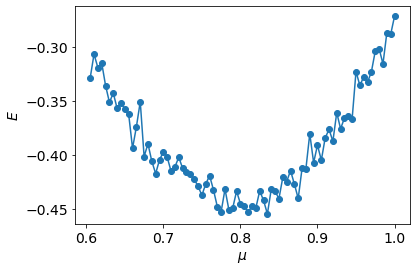

In [6]:
mu, sigma, E = ((np.genfromtxt('output.ene_mu_sigma.0', usecols=i, autostrip=True)) for i in range(3))

print("Energia minima = ", np.min(E))
MU = mu[np.argmin(E)]
print("Valore di mu per energia minima =", MU)

plt.plot(mu, E, 'o-')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$E$')
plt.show()

In [7]:
# Facciamo sì che sigma vari da SIGMA-0.2 a SIGMA+0.2 e mu sia fissato
replace_line('input.dat', 0, '1\n') # = vario sigma
replace_line('input.dat', 1, str(MU)+'\n')
replace_line('input.dat', 2, str(round(SIGMA-0.2,1))+'\n')
subprocess.call("./clean.sh", shell=True)
subprocess.call("./main01.exe")

print("Codice eseguito!")

Codice eseguito!


Energia minima =  -0.460779
Valore di sigma per energia minima = 0.65


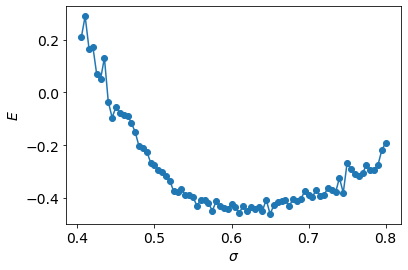

In [8]:
mu, sigma, E = ((np.genfromtxt('output.ene_mu_sigma.0', usecols=i, autostrip=True)) for i in range(3))

print("Energia minima = ", np.min(E))
SIGMA = sigma[np.argmin(E)]
print("Valore di sigma per energia minima =", SIGMA)

plt.plot(sigma, E, 'o-')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$E$')
plt.show()

In [9]:
subprocess.call("cp input.start input.dat", shell=True)

# Facciamo sì che mu vari da MU-0.04 a MU+0.04 e sigma sia fissato
replace_line('input.dat', 0, '2\n') # = vario mu
replace_line('input.dat', 1, str(round(MU-0.04,2))+'\n')
replace_line('input.dat', 2, str(SIGMA)+'\n')
replace_line('input.dat', 3, '0.001\n')

subprocess.call("./clean.sh", shell=True)
subprocess.call("./main01.exe")

print("Codice eseguito!")

Codice eseguito!


Energia minima =  -0.459985
Valore di mu per energia minima = 0.808


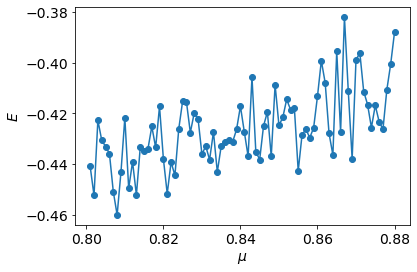

In [10]:
mu, sigma, E = ((np.genfromtxt('output.ene_mu_sigma.0', usecols=i, autostrip=True)) for i in range(3))

print("Energia minima = ", np.min(E))
MU = mu[np.argmin(E)]
print("Valore di mu per energia minima =", MU)

plt.plot(mu, E, 'o-')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$E$')
plt.show()

In [11]:
# Facciamo sì che sigma vari da SIGMA-0.04 a SIGMA+0.04 e mu sia fissato
replace_line('input.dat', 0, '1\n') # = vario sigma
replace_line('input.dat', 1, str(MU)+'\n')
replace_line('input.dat', 2, str(round(SIGMA-0.04,2))+'\n')
subprocess.call("./clean.sh", shell=True)
subprocess.call("./main01.exe")

print("Codice eseguito!")

Codice eseguito!


Energia minima =  -0.462186
Valore di sigma per energia minima = 0.619


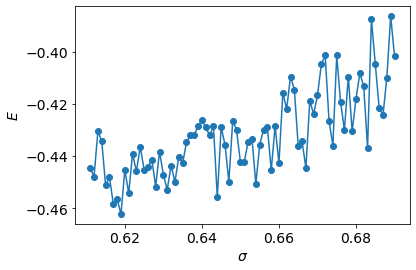

In [12]:
mu, sigma, E = ((np.genfromtxt('output.ene_mu_sigma.0', usecols=i, autostrip=True)) for i in range(3))

print("Energia minima = ", np.min(E))
SIGMA = sigma[np.argmin(E)]
print("Valore di sigma per energia minima =", SIGMA)

plt.plot(sigma, E, 'o-')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$E$')
plt.show()

Questi ultimi due grafici ci restituiscono una stima più precisa di $\mu$ e $\sigma$. Infatti possiamo notare come (nella prima coppia di grafici) l'energia in funzione del parametro considerato mostra chiaramente, in entrambi i casi, un minimo. I valori che $\mu$ e $\sigma$ assumono nei rispettivi minimi sono la nostra stima più precisa per i due parametri (vedi la seconda coppia di grafici).

**N.B.**: ovviamente questi valori di $\sigma$ e $\mu$ potrebbero non essere i migliori in assoluto, infatti nella stima esposta qui sopra non stiamo tenendo conto del fatto che le energie hanno degli errori associati. Quindi l'energia più bassa potrebbe non corrispondere all'effettivo valore dei parametri in cui l'energia (vera) è minima.

Siamo quindi ora pronti a calcolare il valore medio dell' hamiltoniana, con la sua incertezza, in funzione del numero di blocchi e l'istogramma che rappresenta il modulo quadro della funzione d'onda campionata.

Nel primo grafico presentato possiamo osservare che l'energia media del ground state converge attorno a $E_\text{GS} \simeq -0.447$. Questa è una buona stima e si avvicina alla stima ottenuta numericamente $E_\text{GS} \simeq -0.460$.

Nel grafico più sotto mostriamo invece che il codice produce un istogramma che segue perfettamente la curva analitica di $|\Psi_T^{\sigma,\mu}(x)|^2$ (dimostrando che l'algoritmo di Metropolis è efficiente e funzionale); tra l'istogramma è la curva calcolata numericamente si può osservare (facciamo questa osservazione a occhio, senza quantificare) che c'è un discreto accordo (che riflette il buon accordo a livello delle stime dell'energia dello stato fondamentale).

In [13]:
# Ora usiamo mu e sigma calcolate senza variarle
replace_line('input.dat', 0, '0\n') # = NON vario
replace_line('input.dat', 1, str(MU)+'\n')
replace_line('input.dat', 2, str(SIGMA)+'\n')
replace_line('input.dat', 3, '0.00\n') # comando non necessario (scelta "estetica")
replace_line('input.dat', 5, '1000\n') # facciamo più tiri rispetto alle run precedenti
                                       # infatti vogliamo più precisione

subprocess.call("./clean.sh", shell=True)
subprocess.call("./main01.exe")

print("Codice eseguito!")

Codice eseguito!


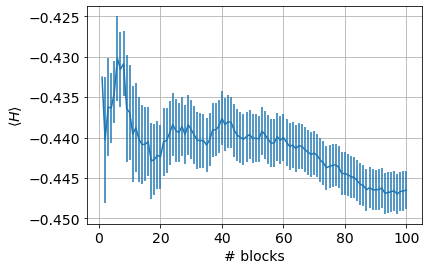

In [14]:
N, E_ist, E, errE = ((np.genfromtxt('output.ene.0', usecols=i, autostrip=True)) for i in range(4))

# Disegno il plot
plt.errorbar(N, E, yerr=errE)
plt.xlabel('# blocks')
plt.ylabel(r'$\langle H\rangle$')
plt.grid(True)
plt.show()

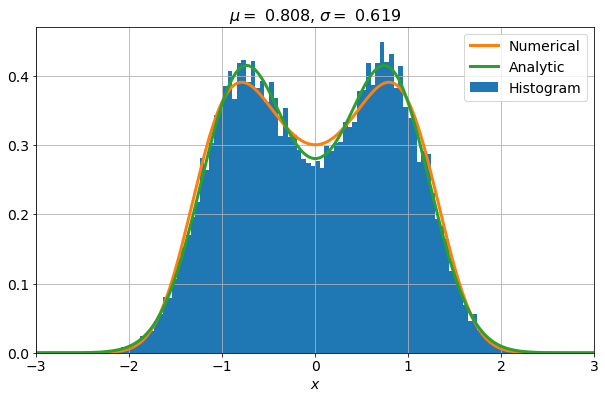

In [15]:
points = np.genfromtxt('points.0', usecols=0, autostrip=True)

plt.subplots(figsize=(10,6))
n, bins, patches = plt.hist(points, bins=100, density=True, label= "Histogram")

x = np.linspace(-a/2, a/2, 1000)
plt.xlim((-3,3))
plt.plot(x, psi[0]**2, label= "Numerical", lw = 3)

def p(x, MU, SIGMA):
    
    return (np.exp(-(x-MU)**2/(2*(SIGMA)**2)) + np.exp(-(x+MU)**2/(2*(SIGMA)**2)))**2

norm = quad(p, -3, 3, args=(MU,SIGMA))[0]

plt.plot(x, p(x,MU,SIGMA)/norm, label = "Analytic", lw = 3)
plt.title(r'$\mu=$ %5.3f, $\sigma=$ %5.3f' %(MU, SIGMA), fontsize=16)
plt.xlabel(r'$x$')
plt.legend(loc=1)
plt.grid(True)

plt.show()

## Esercizio 08.3 

Lo scopo di questo esercizio è simulare il medesimo sistema utilizzando gli algoritmi di Path Integral Ground State (PIGS) (ovvero simulando il sistema a $T=0$) e Path Integral Monte Carlo (PIMC) (ovvero $T>0$).

**Iniziamo con PIGS**. Questo algoritmo consiste nel considerare una corrispondenza uno a uno tra il percorso che compie una particella quantistica e un polimero aperto classico. Il codice dev'essere modificato inserendo il potenziale da noi considerato, $V(x)=x^4+5/2x^2$, e le sue derivate prima e seconda. In questo modo verrà simulato il sistema con l'Hamiltoniana corretta.

In questo caso ($T=0$) vogliamo simulare il sistema proiettando:
1. una funzione d'onda costante $\Psi_T(x)=1$;
2. $\Psi_T^{\sigma,\mu}(x)$ con i parametri stimati nell'*Esercizio 08.2*.

Il primo di questi casi è già implementato nel codice. Il secondo dobbiamo inserirlo noi, dovendo scrivere la funzione d'onda e la sua derivata seconda (necessarie per calcolare la probabilità di accettazione e la variazione dell'energia locale). Abbiamo deciso di modificare il codice in modo da poter decidere se utilizzare la prima o la seconda di queste funzioni d'onda andando a modificare un parametro nel file <font face="Courier" size=3>input.dat</font>.

Il nostro obiettivo è quello di confrontare i risultati dell'esercizio precedente con quelli dell'algoritmo PIGS con entrambe le funzioni d'onda. Mostriamo quindi che queste hanno un ottimo accordo con il calcolo numerico di $|\Psi_\text{GS}(x)|^2$, dimostrandosi più precise di quelle ottenute con il metodo Variational Monte Carlo.

Interrogandoci sul tempo di propagazione immaginario, possiamo osservare nel grafico sottostante che, con $\tau=8$ e con la funzione d'onda costante la PDF viene riprodotta in modo molto preciso. Se invece utilizziamo una funzione d'onda che approssima più accuratamente la $\Psi(x)$ **"vera"** (ovvero se usiamo $\Psi_T^{\sigma,\mu}(x)$), notiamo che il tempo di propagazione immaginario può essere molto più breve e con $\tau=0.5$ otteniamo una curva altrettanto fedele. Andando a diminuire $\tau$ ulteriormente, la $p(x)$ inizia invece ad allontanarsi da quella desiderata.


**ATTENZIONE! Eseguire la prossima cella solo se si ha Root installato sul proprio computer!** 

In [ ]:
# Non avendo root installato sul mio PC non ho potuto eseguire queste celle. Potrebbero contenere alcuni errori.
'''
subprocess.call("cd QMC_1D && make", shell=True)

# ************** tau = 8 **************
subprocess.call("cp QMC_1D/input.pigs QMC_1D/input.dat", shell=True)
# Per avere un'accettazione al 50 %: delta = 0.6, BMReconstructions = 60, BBReconstructions = 120
# Funzione d'onda costante

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIGS_probability_constWF_tau8.dat", shell=True)
subprocess.call("cp QMC_1D/potential.dat QMC_1D/Data/PIGS_potential_constWF_tau8.dat", shell=True)
subprocess.call("cp QMC_1D/kinetic.dat QMC_1D/Data/PIGS_kinetic_constWF_tau8.dat", shell=True)

print("Codice 1 eseguito!")

# ************** tau = 2 **************
replace_line('QMC_1D/input.dat', 2, 'imaginaryTimePropagation\t\t2.0\n') # tau = 2
# Per avere un'accettazione al 50 %
replace_line('QMC_1D/input.dat', 4, 'brownianMotionReconstructions\t\t220\n') # moto browniano
replace_line('QMC_1D/input.dat', 5, 'delta_translation\t\t\t1.1\n') # traslazione
replace_line('QMC_1D/input.dat', 6, 'brownianBridgeReconstructions\t\t280\n') # ponte browniano

# Funzione d'onda gauss + gauss
replace_line('QMC_1D/input.dat', 17, '1\n')

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIGS_probability_NONconstWF_tau2.dat", shell=True)
subprocess.call("cp QMC_1D/potential.dat QMC_1D/Data/PIGS_potential_NONconstWF_tau2.dat", shell=True)
subprocess.call("cp QMC_1D/kinetic.dat QMC_1D/Data/PIGS_kinetic_NONconstWF_tau2.dat", shell=True)

print("Codice 2 eseguito!")

# ************** tau = 0.5 **************
replace_line('QMC_1D/input.dat', 2, 'imaginaryTimePropagation\t\t0.5\n') # tau = 0.5

# In questo caso l'unica accettazione che possiamo regolare attorno al 50% e quella sulla traslazione
replace_line('QMC_1D/input.dat', 5, 'delta_translation\t\t\t2.0\n') # traslazione

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIGS_probability_NONconstWF_tau0.5.dat", shell=True)
#subprocess.call("cp QMC_1D/potential.dat QMC_1D/Data/PIGS_potential_NONconstWF_tau0.5.dat", shell=True)
#subprocess.call("cp QMC_1D/kinetic.dat QMC_1D/Data/PIGS_kinetic_NONconstWF_tau0.5.dat", shell=True)

print("Codice 3 eseguito!")

# ************** tau = 0.5 **************
replace_line('QMC_1D/input.dat', 2, 'imaginaryTimePropagation\t\t0.4\n') # tau = 0.5

# In questo caso l'unica accettazione che possiamo regolare attorno al 50% e quella sulla traslazione
replace_line('QMC_1D/input.dat', 5, 'delta_translation\t\t\t3.0\n') # traslazione

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIGS_probability_NONconstWF_tau0.4.dat", shell=True)
#subprocess.call("cp QMC_1D/potential.dat QMC_1D/Data/PIGS_potential_NONconstWF_tau0.4.dat", shell=True)
#subprocess.call("cp QMC_1D/kinetic.dat QMC_1D/Data/PIGS_kinetic_NONconstWF_tau0.4.dat", shell=True)

print("Codice 4 eseguito!")
'''

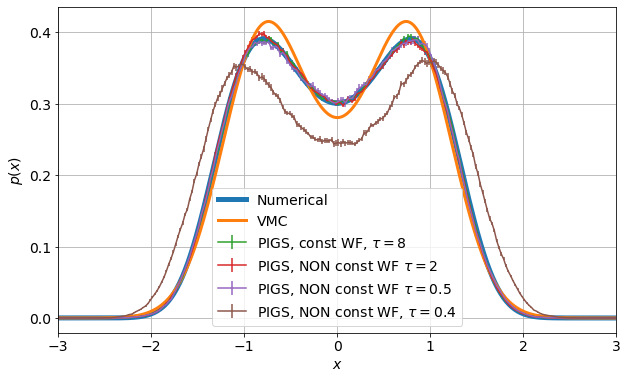

In [17]:
plt.subplots(figsize=(10,6))

# Grafico p(x) numerica
plt.plot(x, psi[0]**2, lw=5.0, label="Numerical")

# Grafico p(x) VMC
plt.plot(x, p(x,MU,SIGMA)/norm, label = "VMC", lw = 3)

#Grafico p(x) PIGS psi(x)=1 tau=8
t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIGS_probability_constWF_tau8.dat', usecols=i, autostrip=True)) for i in range(3))
plt.errorbar(t, P, yerr=errP, label=r"PIGS, const WF, $\tau=8$")

#Grafico p(x) PIGS psi(x)=gauss+gauss tau=2
t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIGS_probability_NONconstWF_tau2.dat', usecols=i, autostrip=True)) for i in range(3))
plt.errorbar(t, P, yerr=errP, label=r"PIGS, NON const WF $\tau=2$")

#Grafico p(x) PIGS psi(x)=gauss+gauss tau=0.5
t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIGS_probability_NONconstWF_tau0.5.dat', usecols=i, autostrip=True)) for i in range(3))
plt.errorbar(t, P, yerr=errP, label=r"PIGS, NON const WF $\tau=0.5$")

t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIGS_probability_NONconstWF_tau0.4.dat', usecols=i, autostrip=True)) for i in range(3))
plt.errorbar(t, P, yerr=errP, label=r"PIGS, NON const WF, $\tau=0.4$")


plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.xlim(-3,3)
plt.legend(loc=0)
plt.grid(True)

plt.show()

Discutiamo ora dell'energia media ottenuta con questo algoritmo. Nei grafici presenti alla cella sottostante mostriamo l'andamento dei valori medi dell'energia potenziale e di quella cinetica per le due diverse $\Psi(x)$. Possiamo notare che se $\Psi(x)=1$ nelle prime e ultime 20 time slice otteniamo un potenziale molto diverso da quello che invece otteniamo se utilizziamo $\Psi(x)=\Psi_T^{\sigma,\mu}(x)$. Questo significa che il valore di aspettazione di $V$ assume un valore preciso solo tra la time slice 20 e la 280.

L'energia cinetica invece ha valori compatibili nei due casi.

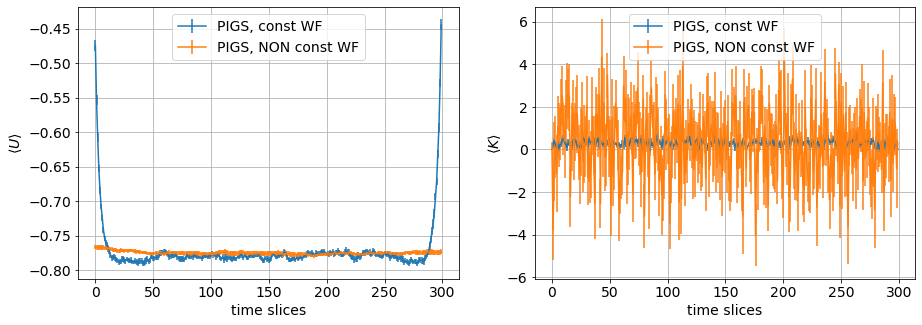

In [18]:
N1, Kin, errK = ((np.genfromtxt('./QMC_1D/Data/PIGS_kinetic_constWF_tau8.dat', usecols=i, autostrip=True)) for i in range(3))
N1, Pot, errPot = ((np.genfromtxt('./QMC_1D/Data/PIGS_potential_constWF_tau8.dat', usecols=i, autostrip=True)) for i in range(3))

N2, Kin1, errK1 = ((np.genfromtxt('./QMC_1D/Data/PIGS_kinetic_NONconstWF_tau0.5.dat', usecols=i, autostrip=True)) for i in range(3))
N2, Pot1, errPot1 = ((np.genfromtxt('./QMC_1D/Data/PIGS_potential_NONconstWF_tau0.5.dat', usecols=i, autostrip=True)) for i in range(3))


plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(N1, Pot, yerr=errPot, label="PIGS, const WF")
plt.errorbar(N2, Pot1, yerr=errPot1, label="PIGS, NON const WF")
plt.xlabel('time slices')
plt.ylabel(r'$\langle U\rangle$')
plt.grid(True)
plt.legend(loc=0)


plt.subplot(1,2,2)
plt.errorbar(N1, Kin, yerr=errK, label="PIGS, const WF")
plt.errorbar(N2, Kin1, yerr=errK1, label="PIGS, NON const WF")
plt.xlabel('time slices')
plt.ylabel(r'$\langle K\rangle$')
plt.legend(loc=9)
plt.grid(True)

plt.show()

Ora sommiamo l'energia potenziale con quella cinetica e, con la propagazione dell'errore, calcoliamo l'errore relativo all' energia totale media. In questo modo abbiamo quindi il grafico di $\langle H\rangle$ al variare delle time slice. Possiamo sovrappore questo grafico col valore finale calcolato con il metodo VMC e osserviamo che si ha compatibilità con questo valore per tutte le time slice.

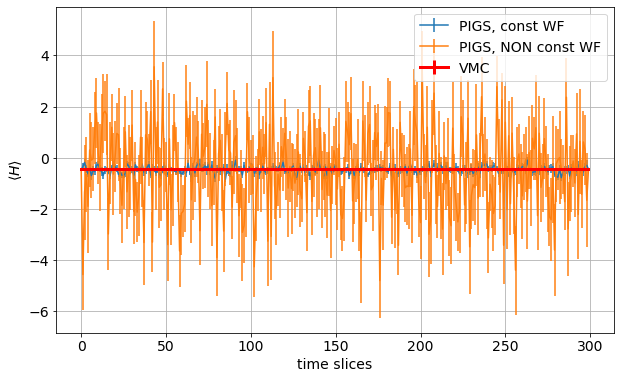

In [19]:
E1 = Kin + Pot
errE1 = np.sqrt(errK**2 + errPot**2)
E2 = Kin1 + Pot1
errE2 = np.sqrt(errK1**2 + errPot1**2)

e = np.linspace(0,300,300) * 0 + E[-1]
err = np.linspace(0,300,300) * 0 + errE[-1]

# Disegno il plot

plt.subplots(figsize=(10,6))
plt.errorbar(N1, E1, yerr=errE1, label="PIGS, const WF")
plt.errorbar(N2, E2, yerr=errE2, label="PIGS, NON const WF")
plt.errorbar(N1, e, yerr=err, label="VMC", lw=3.0, color="red")

plt.legend(loc=1)


plt.xlabel('time slices')
plt.ylabel(r'$\langle H\rangle$')
plt.grid(True)
plt.show()

Ora utilizzeremo l'**algoritmo PIMC** e studieremo come cambia l'istogramma di $|\Psi(x)|^2$ andando a modificare la temperatura a cui simuliamo il sistema. 

**DÌ QUALCOSA SU ACCETTAZIONE TRASLAZ (CHE PONI AL 50%) E ACCETTAZIONE BROWNIAN BRIDGE!!**

T=1 50% e BB 83% (alta va bene! il campionamento della parte cinetica è un importance sampling quasi esatto!)

Il grafico (in cui plottiamo $|\Psi(x)|^2$ per $T=1,T=10,T=100$) mostra chiaramente che, all'aumentare della temperatura la sovrapposizione tra l'istogramma desiderato e quello che viene effettivamente ottenuto diminuisce sempre più. Questo accade perché aumentando la temperatura, il sistema potrà occupare un numero sempre maggiore di stati eccitati e quindi le probabilità di occupare determinate posizioni cambieranno a seconda della temperatura a cui simuli il sistema.

In [ ]:
'''
# ************** T = 1 **************
subprocess.call("cp QMC_1D/input.pimc QMC_1D/input.dat", shell=True)

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIMC_probability_T1.dat", shell=True)

print("Codice 1 eseguito!")

# ************** T = 10 **************i
replace_line('QMC_1D/input.dat', 1, 'temperature \t\t\t\t10.00\n') # T = 10

# Per avere un'accettazione al 50 %
replace_line('QMC_1D/input.dat', 5, 'delta_translation\t\t\t3.5\n') # traslazione

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIMC_probability_T10.dat", shell=True)

print("Codice 2 eseguito!")

# ************** T = 100 **************i
replace_line('QMC_1D/input.dat', 1, 'temperature \t\t\t\t100.00\n') # T = 100

# accettazione al 50%
replace_line('QMC_1D/input.dat', 5, 'delta_translation\t\t\t6.5\n') # traslazione

subprocess.call("cd QMC_1D/; make exec", shell=True)

# Copio i file nella cartella Data
subprocess.call("cp QMC_1D/probability.dat QMC_1D/Data/PIMC_probability_T100.dat", shell=True)

print("Codice 3 eseguito!")
'''

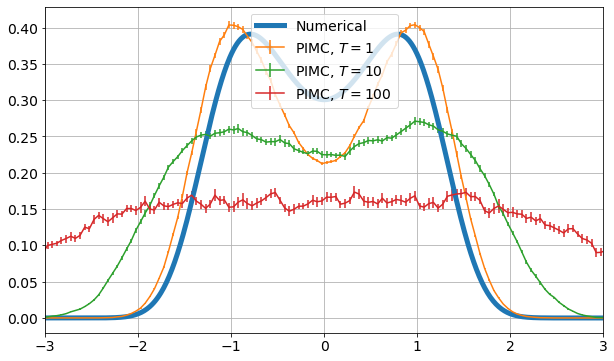

In [21]:
plt.subplots(figsize=(10,6))

plt.plot(x, psi[0]**2, lw=5.0, label="Numerical")

t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIMC_probability_T1.dat', usecols=i, autostrip=True)) for i in range(3))

plt.errorbar(t, P, yerr=errP, label=r"PIMC, $T=1$")

t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIMC_probability_T10.dat', usecols=i, autostrip=True)) for i in range(3))

plt.errorbar(t, P, yerr=errP, label=r"PIMC, $T=10$")

t, P, errP = ((np.genfromtxt('./QMC_1D/Data/PIMC_probability_T100.dat', usecols=i, autostrip=True)) for i in range(3))

plt.errorbar(t, P, yerr=errP, label=r"PIMC, $T=100$")

plt.xlim(-3,3)
plt.legend(loc=9)
plt.grid(True)
plt.show()